# Spot or bin resolutions

Our main tutorials focus on imaging-based technologies such as Xenium or MERSCOPE data. Still, you can use Novae on NGS-based technologies such as Visium or Visium HD data. Since the resolution is highly different, we split this tutorial into two main sections: one for Visium-like technologies, and one for VisiumHD-like technologies.


## Visium HD usage

For technologies with small bins such as VisiumHD data, you have two possibilities: you can either work on the cells themselves, or on the bins.

### Option 1: Going at the single-cell resolution

You can also use this [Visium HD tutorial](https://gustaveroussy.github.io/sopa/tutorials/visium_hd/) from Sopa to segment cells on the H&E image and then aggregate the 2um bins inside the cells. This way, you'll have a single-cell resolution table, similar to what we get with Xenium or MERSCOPE data.

Then, based on this single-cell table, you can follow the ["normal usage" tutorial](../main_usage).


### Option 2: Using the 8um bins

You can use [spatialdata_io](https://spatialdata.scverse.org/projects/io/en/latest/generated/spatialdata_io.visium_hd.html) to read the output of SpaceRanger, it will create a SpatialData object containing multiple `AnnData` objects for the bins. You can simply use the `AnnData` corresponding to the 8um bins, which is the one that is the closest to a typical cell size.

Then, you can use a pre-trained model (in zero-shot or fine-tuning as in the other tutorial), but since the nature of the data is different, you can also re-train a model like below.

> For more customization, like using a GPU, you can look at the [API](../../api/Novae) or the [FAQ](../../faq).


In [13]:
import novae
import scanpy as sc

You can load the output of Space Ranger as below. You can skip this step for the tutorial, as we'll load an existing dataset afterward.

NB: `spatialdata_io` can be installed via `pip install spatialdata-io`


In [ ]:
import spatialdata_io

# open the output of Space Ranger as a spatialdata object
sdata = spatialdata_io.visium_hd("/path/to/spaceranger_output_dir")

# get the AnnData object corresponding to the 8 microns bins
adata = sdata["square_008um"]

For the sake of this tutorial, we'll directly load the first 8um-bins `AnnData` object from the Novae database:


In [ ]:
adata = novae.utils.load_dataset(technology="visium_hd")[0]

We can run some basic filtering, e.g. we remove the bins with less than 10 counts, and we filter low-expressed genes.


In [ ]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=1_000)

Then, we create the graph of spatial neighbors. We specify `technology="visium_hd"` to use the grid structure of the 8um bins.


In [4]:
novae.utils.spatial_neighbors(adata, technology="visium_hd")

[INFO] (novae.utils._build) Computing graph on 600,414 cells (coord_type=grid, delaunay=False, radius=None, n_neighs=8)


We see that the graph is highly connected, except for some regions on the right (see the bins in red):


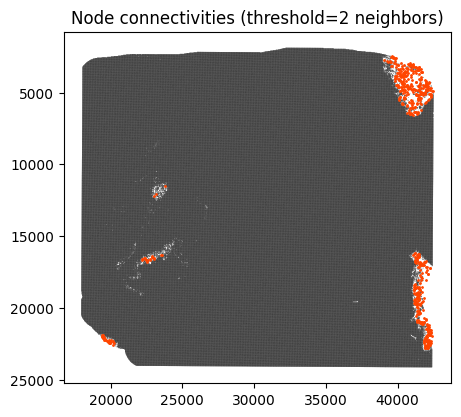

In [5]:
novae.plot.connectivities(adata)

Then we create a new Novae model.


In [6]:
model = novae.Novae(adata)
model

[INFO] (novae.utils._validate) Preprocessed 1 adata object(s) with sc.pp.normalize_total and sc.pp.log1p (raw counts were saved in adata.layers['counts'])
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO] (novae.module.embed) Running PCA embedding initialization


Novae model
   ├── Known genes: 672
   ├── Parameters: 573.7K
   └── Model name: None

Then, we can train the model with the [`fit`](../../api/Novae/#novae.Novae.fit) method:

> Refer to the API to use a GPU.


In [ ]:
model.fit(max_epochs=10)  # or more epochs

Then, the usage of Novae is similar to the other tutorials.

That is, we start by computing the bins representations via [`compute_representations`](../../api/Novae/#novae.Novae.compute_representations):


In [ ]:
model.compute_representations()

Then, we assign each bin representation to a spatial domain using the [`assign_domains`](../../api/Novae/#novae.Novae.assign_domains) method:


In [ ]:
model.assign_domains(level=8)  # or more domains

Finally, we can plot these domains using [`novae.plot.domains`](../../api/plot/#novae.plot.domains):


[INFO] (novae.utils._validate) Using obs_key='novae_domains_8' by default.


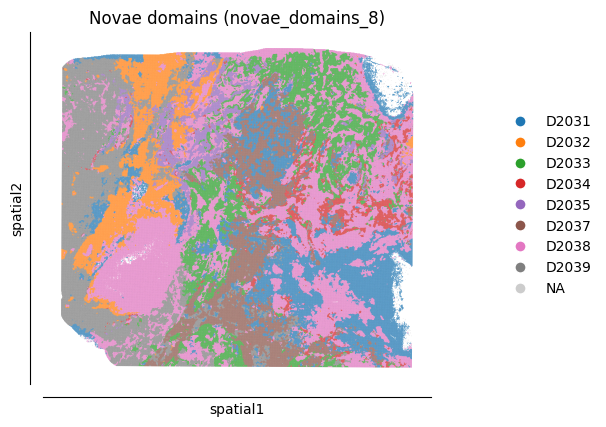

In [42]:
novae.plot.domains(adata, cell_size=35)

## Visium data

We don't have **yet** a foundation model for spot-based technologies. This may be added in the future.

Meanwhile, you can train a Novae model on your dataset. Since Visium datasets have a relatively low number of spots (usually less than 100,000 spots), training a new Novae model is very fast.

> For more customization, like using a GPU, you can look at the [API](../../api/Novae) or the [FAQ](../../faq).

> NB: you may experience lower performances than for other technologies as long as we don't release a Visium foundation model.


In [1]:
import novae
import scanpy as sc

In [2]:
adatas = novae.utils.load_dataset(technology="visium")

adata = sc.concat(adatas, index_unique="-")

[INFO] (novae.utils._data) Found 3 h5ad file(s) matching the filters.


Now, we can create the graph of spot neighbors.

Here, since we merged the `AnnData` into a single `adata`, we need to precise `slide_key="slide_id"`, where slide_id is the name of the column in `adata.obs` containing the ID of each slide.


In [3]:
novae.spatial_neighbors(adata, technology="visium", slide_key="slide_id")

[INFO] (novae.utils._build) Computing graph on 10,904 cells (coord_type=grid, delaunay=False, radius=None, n_neighs=6)


We can show which spots (in red) are not connected to enough neighbors:


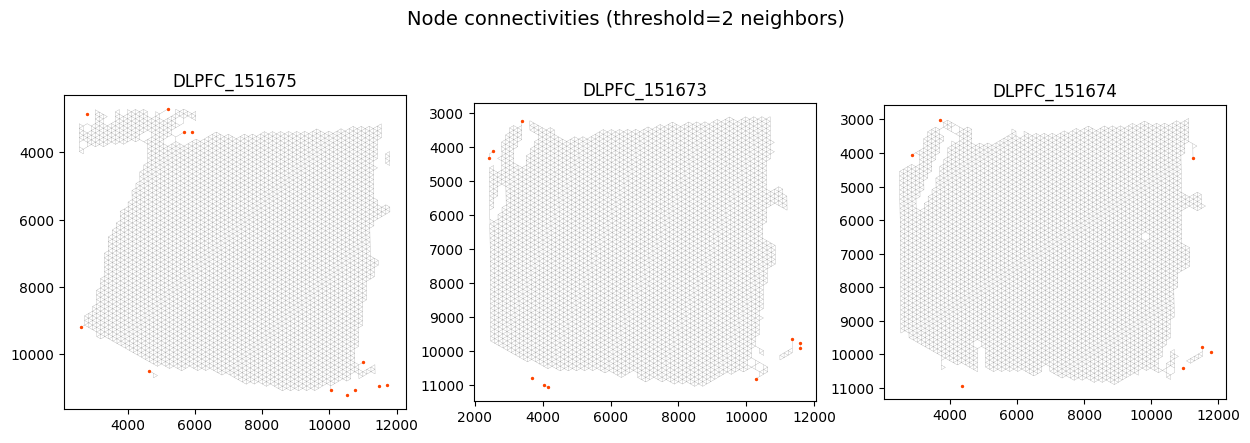

In [4]:
novae.plot.connectivities(adata)

Then, we perform basic preprocessing: here, we keep only the top 3,000 highly variable genes.


In [ ]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
adata = adata[:, adata.var["highly_variable"]].copy()

Then we create a new Novae model.

**Importantly**, since the Visium resolution is lower, we set `n_hops_local=1, n_hops_view=1`, which are the hyperparameters used to define the neighborhoods. I.e., the spot neighbors will be only composed of their direct spot neighbors.


In [6]:
model = novae.Novae(adata, n_hops_local=1, n_hops_view=1, panel_subset_size=0.6)
model

[INFO] (novae.utils._validate) Preprocessed 1 adata object(s) with sc.pp.normalize_total and sc.pp.log1p (raw counts were saved in adata.layers['counts'])
[INFO] (novae.module.embed) Running PCA embedding initialization


Novae model
   ├── Known genes: 3000
   ├── Parameters: 806.5K
   └── Model name: None

Then, we can train the model with the [`fit`](../../api/Novae/#novae.Novae.fit) method:

> Refer to the API to use a GPU.


In [ ]:
model.fit()

Then, the usage of Novae is similar to the other tutorials.

That is, we start by computing the spots representations via [`compute_representations`](../../api/Novae/#novae.Novae.compute_representations):


In [8]:
model.compute_representations()

Computing representations:   0%|          | 0/43 [00:00<?, ?it/s]

Then, we assign each spot representation to a spatial domain using the [`assign_domains`](../../api/Novae/#novae.Novae.assign_domains) method:


In [9]:
model.assign_domains()

'novae_domains_7'

Finally, we can plot these domains using [`novae.plot.domains`](../../api/plot/#novae.plot.domains):


[INFO] (novae.utils._validate) Using obs_key='novae_domains_7' by default.


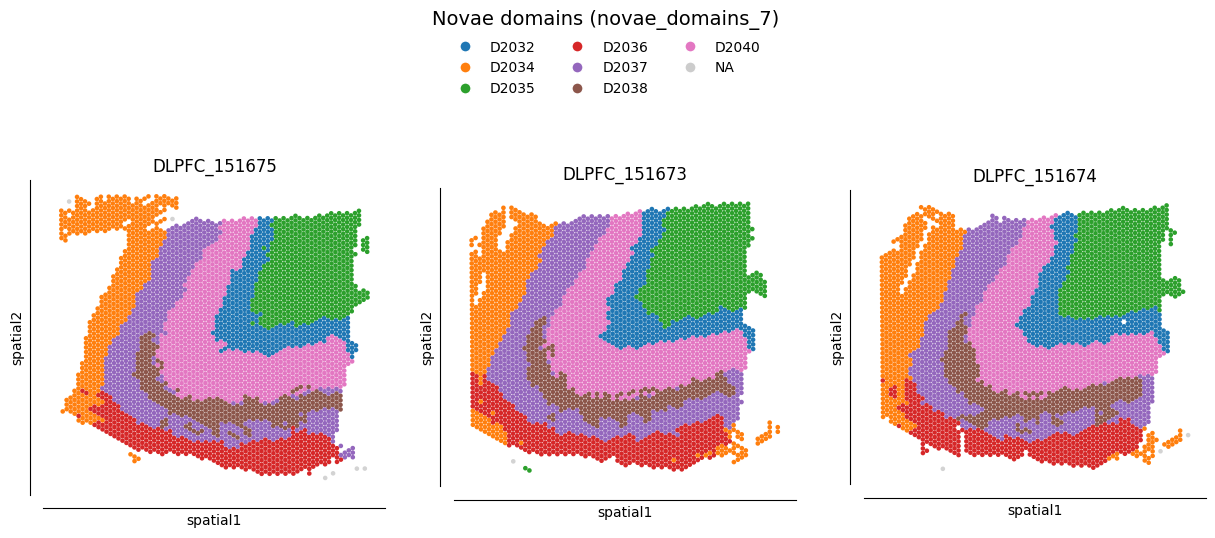

In [10]:
novae.plot.domains(adata)